# How to force function calling agent to structure output

You might want your agent to return its output in a structured format. For example, if the output of the agent is used by some other downstream software, you may want the output to be in the same structured format every time the agent is invoked to ensure consistency.

This notebook will walk through two different options for forcing a function calling agent to structure its output. We will be using a basic [ReAct agent](https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/) (a model node and a tool-calling node) together with a third node at the end that will format response for the user. 

The first way you can force your tool calling agent to have structured output is to use a second LLM (in this case `model_with_structured_output`) to respond to the user. 

In this case, you will define a basic ReAct agent normally, but instead of having the `agent` node choose between the `tools` node and ending the conversation, the `agent` node will choose between the `tools` node and the `respond` node. The `respond` node will contain a second LLM that uses structured output, and once called will return directly to the user. You can think of this method as basic ReAct with one extra step before responding to the user. 

The benefit of this method is that it guarantees structured output (as long as `.with_structured_output` works as expected with the LLM). The downside to using this approach is that it requires making an additional LLM call before responding to the user, which can increase costs as well as latency.

The second way you can force your tool calling agent to have structured output is to bind the output you would like as an additional tool for the `agent` node to use. In contrast to the basic ReAct agent, the `agent` node in this case is not selecting between `tools` and `END` but rather selecting between the specific tools it calls. The expected flow in this case is that the LLM in the `agent` node will first select the action tool, and after receiving the action tool output it will call the response tool, which will then route to the `respond` node which simply structures the arguments from the `agent` node tool call.

The benefit to this format is that you only need one LLM, and can save money and latency because of this. The downside to this option is that it isn't guaranteed that the single LLM will call the correct tool when you want it to. We can help the LLM by setting `tool_choice` to `any` when we use `bind_tools` which forces the LLM to select at least one tool at every turn, but this is far from a fool proof strategy.

Note that both of these options will follow the exact same graph structure (see the diagrams below), in that they are both exact replicas of the basic ReAct architecture but with a `respond` node before the end.

## Setup

For our setup we need to define how we want to structure our output, define our graph state, and also our tools and the models we are going to use.

To use structured output, we will use the `with_structured_output` method from LangChain, which you can read more about [here](https://python.langchain.com/v0.2/docs/how_to/structured_output/).

We are going to use a single tool in this example for finding the weather, and will return a structured weather response to the user.

In [22]:
from pydantic import BaseModel, Field
from typing import Annotated, Any, TypedDict, Literal
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langchain_anthropic import ChatAnthropic

class WeatherResponse(BaseModel):
    temperature: float = Field(description="The temperature in fahrenheit")
    wind_directon: str = Field(description="The direction of the wind in abbreviated form")
    wind_speed: float = Field(description="The speed of the wind in km/h")

class AgentState(TypedDict):
    # list of chat messages from user, LLM, and tools
    messages: Annotated[list, add_messages]
    # Final structured response from the agent
    final_response: WeatherResponse

@tool
def get_weather(city: Literal["nyc", "sf"]):
    """Use this to get weather information."""
    if city == "nyc":
        return "It is cloudy in NYC, with 5 mph winds in the North-East direction and a temperature of 70 degrees"
    elif city == "sf":
        return "It is 75 degrees and sunny in SF, with 3 mph winds in the South-East direction"
    else:
        raise AssertionError("Unknown city")
    
tools = [get_weather]
    
model = ChatAnthropic(model="claude-3-opus-20240229")
    
model_with_tools = model.bind_tools(tools)
model_with_structured_output = model.with_structured_output(WeatherResponse)

## Option 1: 2 LLMs

Let's now dive into how we would use a second LLM to force structured output.

### Define Graph

We can now define our graph:

In [18]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage

# Define the function that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we respond to the user
    if not last_message.tool_calls:
        return "respond"
    # Otherwise if there is, we continue
    else:
        return "continue"

# Define the function that calls the model
def call_model(state: AgentState):
    response = model_with_tools.invoke(state['messages'])
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Define the function that responds to the user
def respond(state: AgentState):
    # We call the model with structured output in order to return the same format to the user every time
    # state['messages'][-2] is the last ToolMessage in the convo, which we convert to a HumanMessage for the model to use
    # We could also pass the entire chat history, but this saves tokens since all we care to structure is the output of the tool
    response = model_with_structured_output.invoke([HumanMessage(content=state['messages'][-2].content)])
    # We return the final answer
    return {"final_response": response}


# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("respond", respond)
workflow.add_node("tools", ToolNode(tools))

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)
graph = workflow.compile()

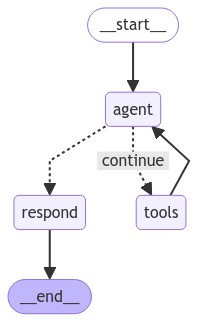

In [23]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

As the diagram shows, we have simply inserted an extra node before the end that will call a second LLM with structured output to guarantee the user receives the output in the format they were expecting. You can scroll down the page to verify that the other method for generating structured output has the same graph structure, but with a different underlying mechanism.

### Usage

We can now invoke our graph to verify that the output is being structured as desired:

In [19]:
answer = graph.invoke(input={"messages": [("human", "what's the weather in SF?")]})['final_response']

In [ ]:
answer

WeatherResponse(temperature=75.0, wind_directon='SE', wind_speed=3.0)

As we can see, the agent returned a `WeatherResponse` object as we expected. If would now be easy to use this agent in a more complex software stack without having to worry about the output of the agent not matching the format expected from the next step in the stack.

## Option 2: Bind output as tool

Let's now examine how we would use the single LLM option.

### Define Graph

The graph definition is very similar to the one above, the only difference is we no longer call an LLM in the `response` node, and instead bind the `WeatherResponse` tool to our LLM that already contains the `get_weather` tool.

In [26]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

tools = [get_weather, WeatherResponse]

# Force the model to use tools by passing tool_choice="any"    
model_with_response_tool = model.bind_tools(tools,tool_choice="any")

# Define the function that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is only one tool call and it is the response tool call we respond to the user
    if len(last_message.tool_calls) == 1 and last_message.tool_calls[0]['name'] == "WeatherResponse":
        return "respond"
    # Otherwise we will use the tool node again
    else:
        return "continue"

# Define the function that calls the model
def call_model(state: AgentState):
    response = model_with_response_tool.invoke(state['messages'])
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Define the function that responds to the user
def respond(state: AgentState):
    # Construct the final answer from the arguments of the last tool call
    response = WeatherResponse(**state['messages'][-1].tool_calls[0]['args'])
    # We return the final answer
    return {"final_response": response}


# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("respond", respond)
workflow.add_node("tools", ToolNode(tools))

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)
graph = workflow.compile()

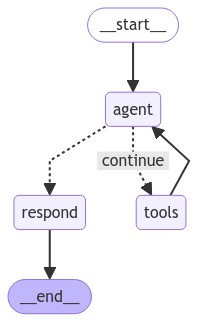

In [27]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

As you can see the graph in this case looks the exact same to the one used in the 2 LLMs option. The only difference is that the `respond` node in this case does not involve a second LLM, and simply formats the output of the tool call that comes from the `agent` node.

### Usage

Now we can run our graph to check that it worked as intended:

In [28]:
answer = graph.invoke(input={"messages": [("human", "what's the weather in SF?")]})['final_response']

In [29]:
answer

WeatherResponse(temperature=75.0, wind_directon='SE', wind_speed=3.0)

Again, the agent returned a `WeatherResponse` object as we expected.